# Create Hexagons

#### !!! As this notebook uses h3 package it will NOT WORK ON WINDOWS !!!

This notebook creates hexagons lying above the bounding boxes of the city Dresden. For spatial analysis these hexagons are very helpful.

### What is done?
1. Load GeoJSON of Dresdens bounding box
2. Polyfill region of Dresden with Hexagons by given resolution
3. Plot and save the hexagons in a dataframe and csv
4. Match corresponding hexagons to start and endpoints of trips
5. Save them into csv file chunks
    - This has to be done because the file is too big to be uplaoded to Github
    - But as h3 package is not working on Windows, we have to upload these files so everyone has these information
    - The next notebook (03_MergeHexagonChunks) can then be run on Windows
    - It loads the chunks and merges them again, creating a Trips_Hexagons.csv (which is on gitignore)

### Input

- data/output/Trips.csv
- data/input/dresden_bounding_box.geojson

### Output
- data/output/hexagons-dresden.csv
- data/output/trips-hexagons/trips-hexagons-{id}.csv
    - (Multiple chunkfiles, each with antoher number as id)
    
---------------------------------------------------------

## 0. Pre-Installations of packages
Copy one of these lines into the next cell. Beware: pip does not like comments so paste it, run the cell and delete it again!
- pip install geopandas
- pip install h3
- pip install matplotlib
- pip install descartes

  Using cached descartes-1.1.0-py3-none-any.whl (5.8 kB)
Note: you may need to restart the kernel to use updated packages.


In [1]:
import pandas as pd
import geopandas
import os
import json
import numpy as np
from h3 import h3
from shapely.geometry import shape
import matplotlib.pyplot as plt

In [2]:
path_trips=os.path.join(os.getcwd(), '..', 'data', 'output', 'Trips.csv')
path_output=os.path.join(os.getcwd(), '..', 'data', 'output')
path_geo =os.path.join(os.getcwd(), '..', 'data', 'input', 'geodata', 'dresden_bounding_box.geojson')

print("Trips path:", path_trips)
print("Output path:", path_output)
print("GeoJSON path:", path_geo)

Trips path: /Users/mstroh/PycharmProjects/AAA_Jupyter_Explorers/notebooks/../data/output/Trips.csv
Output path: /Users/mstroh/PycharmProjects/AAA_Jupyter_Explorers/notebooks/../data/output
GeoJSON path: /Users/mstroh/PycharmProjects/AAA_Jupyter_Explorers/notebooks/../data/input/geodata/dresden_bounding_box.geojson


## 1. Load GeoJSON of Dresdens bounding box
Use Geopandas to read geojson file

In [3]:
city_bounding_box = geopandas.read_file(path_geo)
city_bounding_box_json_string = city_bounding_box.to_json()
city_bounding_box_json = json.loads(city_bounding_box_json_string)
city_bounding_box_poly = city_bounding_box_json["features"][0]

In [4]:
# Valid GeoJSON object
city_bounding_box_poly["geometry"]

{'type': 'Polygon',
 'coordinates': [[[13.746466, 51.178629],
   [13.964722, 51.06278],
   [13.815186, 50.974527],
   [13.572688, 51.0637],
   [13.746466, 51.178629]]]}

## 2. Polyfill region of Dresden with Hexagons by given resolution

In [41]:
# Computing hexagons for a given polygon
polygon_obj = city_bounding_box_poly["geometry"] # your geo json object

H3_HEXAGON_RESOLUTION_SMALL = 7
hexagons_small = h3.polyfill(polygon_obj, res = H3_HEXAGON_RESOLUTION_SMALL, geo_json_conformant = True)
H3_HEXAGON_RESOLUTION_BIG = 6
hexagons_big = h3.polyfill(polygon_obj, res = H3_HEXAGON_RESOLUTION_BIG, geo_json_conformant = True)

In [44]:
# Returns only the index of each hexagon, not the geometries
print("SMALL HEXAGONS:")
print(hexagons_small)
print()
print("BIG HEXAGONS:")
print(hexagons_big)

SMALL HEXAGONS:
{'871f1b558ffffff', '871f1b540ffffff', '871f1b569ffffff', '871f1b463ffffff', '871f1b093ffffff', '871f1b46effffff', '871f1b46cffffff', '871f1b0b0ffffff', '871f1b086ffffff', '871f1b54cffffff', '871f1b464ffffff', '871f1b466ffffff', '871f1b541ffffff', '871f1b098ffffff', '871f1b0b2ffffff', '871f1b083ffffff', '871f1b0b1ffffff', '871f1b091ffffff', '871f1b096ffffff', '871f1b54affffff', '871f1b551ffffff', '871f1b555ffffff', '871f1b461ffffff', '871f1b0b4ffffff', '871f1b543ffffff', '871f1b55cffffff', '871f1b56affffff', '871f1b445ffffff', '871f1b469ffffff', '871f1b19affffff', '871f1b54bffffff', '871f1b559ffffff', '871f1b468ffffff', '871f1b090ffffff', '871f1b55dffffff', '871f1b19bffffff', '871f1b09cffffff', '871f1b09dffffff', '871f1b092ffffff', '871f1b09bffffff', '871f1b56dffffff', '871f1b545ffffff', '871f1b465ffffff', '871f1b09effffff', '871f1b09affffff', '871f1b46dffffff', '871f1b19effffff', '871f1b082ffffff', '871f1b542ffffff', '871f1b549ffffff', '871f1b46bffffff', '871f1b080ffff

## 3. Plot and save the hexagons in a dataframe and csv
### 3.1. Convert H3 Indexes to Geometry Objects

In [45]:
# Create geo data frame for small hexagons (resolution = 7)
df_hexagons_small = geopandas.GeoDataFrame(list(hexagons_small), columns=['h3_hex_small_id'], crs="EPSG:4326")

df_hexagons_small['geometry'] = df_hexagons_small[(df_hexagons_small['h3_hex_small_id'].notna())].apply(lambda row: shape({"type": "Polygon",
                                           "coordinates": [h3.h3_to_geo_boundary(row["h3_hex_small_id"], geo_json=True)],
                                           "properties": ""
                                           }), axis=1)

# Create geo data frame for big hexagons (resolution = 6)
df_hexagons_big = geopandas.GeoDataFrame(list(hexagons_big), columns=['h3_hex_big_id'], crs="EPSG:4326")

df_hexagons_big['geometry'] = df_hexagons_big[(df_hexagons_big['h3_hex_big_id'].notna())].apply(lambda row: shape({"type": "Polygon",
                                           "coordinates": [h3.h3_to_geo_boundary(row["h3_hex_big_id"], geo_json=True)],
                                           "properties": ""
                                           }), axis=1)

### 3.2. Simply plot hexagons and print dataframe

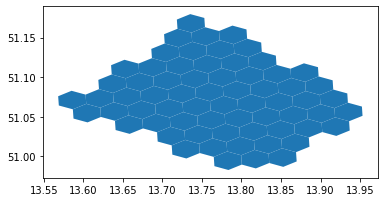

In [46]:
df_hexagons_small.plot()

In [48]:
df_hexagons_small

,h3_hex_small_id,geometry
0,871f1b558ffffff,"POLYGON ((13.64005 51.04486, 13.64087 51.03314..."
1,871f1b540ffffff,"POLYGON ((13.61904 51.09652, 13.61986 51.08482..."
2,871f1b569ffffff,"POLYGON ((13.72071 51.13774, 13.72152 51.12604..."
3,871f1b463ffffff,"POLYGON ((13.74647 51.01578, 13.74726 51.00406..."
4,871f1b093ffffff,"POLYGON ((13.81345 51.05495, 13.81423 51.04323..."
...,...,...
61,871f1b54effffff,"POLYGON ((13.67229 51.08203, 13.67310 51.07032..."
62,871f1b548ffffff,"POLYGON ((13.70698 51.08406, 13.70778 51.07235..."
63,871f1b54dffffff,"POLYGON ((13.72312 51.10263, 13.72392 51.09093..."
64,871f1b0b6ffffff,"POLYGON ((13.73928 51.12120, 13.74008 51.10950..."


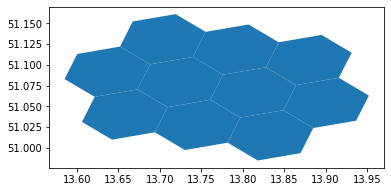

In [49]:
df_hexagons_big.plot()

In [50]:
df_hexagons_big

,h3_hex_big_id,geometry
0,861f1b467ffffff,"POLYGON ((13.70939233335146 51.04892282240107,..."
1,861f1b087ffffff,"POLYGON ((13.84345217144361 51.12720543733009,..."
2,861f1b09fffffff,"POLYGON ((13.86432751736583 51.07550117594182,..."
3,861f1b46fffffff,"POLYGON ((13.79728558598623 51.03637274669753,..."
4,861f1b0b7ffffff,"POLYGON ((13.75543874334306 51.13976093214367,..."
5,861f1b097ffffff,"POLYGON ((13.77637694704919 51.08808996190518,..."
6,861f1b547ffffff,"POLYGON ((13.60046007155825 51.11305144151748,..."
7,861f1b54fffffff,"POLYGON ((13.68842099374826 51.10060671369379,..."
8,861f1b56fffffff,"POLYGON ((13.66742002342612 51.15224433237433,..."
9,861f1b55fffffff,"POLYGON ((13.62149402016324 51.06140093438403,..."


### 3.3. Save hexagons as csv

In [53]:
df_hexagons_small.to_csv(os.path.join(path_output, "hexagons-small-dresden.csv"))

In [54]:
df_hexagons_big.to_csv(os.path.join(path_output, "hexagons-big-dresden.csv"))

## 4. Match corresponding hexagons to start and endpoints of trips

In [56]:
df_trips = pd.read_csv(path_trips, index_col="Unnamed: 0")
df_trips.head()

,p_spot_start,b_lock_types_start,p_maintenance_start,p_bike_racks_start,p_place_type_start,p_number_start,p_uid_start,b_number_start,p_free_racks_start,b_boardcomputer_start,...,p_booked_bikes_end,p_name_end,p_lat_end,air_deg,air_hum,rain_mm,rain_yn,sun_hour,wind_ms,trip_duration
0,False,analog_code_lock,False,0,12,0.0,12095573,93771,0,22532,...,0,BIKE 93771,51.046234,-3.3,75.3,0.0,0.0,0.0,4.3,28.0
1,True,analog_code_lock,False,0,0,4486.0,10299640,93576,0,0,...,0,BIKE 93576,51.049069,-3.3,75.3,0.0,0.0,0.0,4.3,10.0
2,True,frame_lock,False,0,0,4483.0,10299584,93440,0,7551004130,...,0,Wundtstr. / Zellescher Weg,51.028370,-3.3,75.3,0.0,0.0,0.0,4.3,26.0
3,False,analog_code_lock,False,0,12,0.0,12098234,93322,0,1265,...,0,BIKE 93322,51.041798,-3.3,75.3,0.0,0.0,0.0,4.3,2.0
4,True,analog_code_lock,False,0,0,4373.0,264575,93585,0,0,...,0,Friedensstraße/Conradstr.,51.071740,-3.3,75.3,0.0,0.0,0.0,4.3,28.0


In [57]:
df_trips.columns

Index(['p_spot_start', 'b_lock_types_start', 'p_maintenance_start',
       'p_bike_racks_start', 'p_place_type_start', 'p_number_start',
       'p_uid_start', 'b_number_start', 'p_free_racks_start',
       'b_boardcomputer_start', 'datetime_start', 'p_lng_start',
       'b_electric_lock_start', 'p_bikes_start', 'p_booked_bikes_start',
       'p_name_start', 'b_bike_type_start', 'p_lat_start', 'p_spot_end',
       'p_maintenance_end', 'p_bike_racks_end', 'p_place_type_end',
       'p_number_end', 'p_uid_end', 'p_free_racks_end', 'datetime_end',
       'p_lng_end', 'p_bikes_end', 'p_booked_bikes_end', 'p_name_end',
       'p_lat_end', 'air_deg', 'air_hum', 'rain_mm', 'rain_yn', 'sun_hour',
       'wind_ms', 'trip_duration'],
      dtype='object')

In [58]:
# Get the hexagon for a data point
# Assume we have a dataframe with a column for latitude and longitude representing "point data".

# Add hex ids for small hexagons and for start and end point
df_trips["h3_hex_small_id_start"] = df_trips.apply(lambda row: h3.geo_to_h3(row["p_lat_start"], row["p_lng_start"], H3_HEXAGON_RESOLUTION_SMALL) if (row['p_lat_start'] and row['p_lng_start']) else 0, axis=1)
df_trips["h3_hex_small_id_end"] = df_trips.apply(lambda row: h3.geo_to_h3(row["p_lat_end"], row["p_lng_end"], H3_HEXAGON_RESOLUTION_SMALL) if (row['p_lat_end'] and row['p_lng_end']) else 0, axis=1)

# Add hex ids for big hexagons and for start and end point
df_trips["h3_hex_big_id_start"] = df_trips.apply(lambda row: h3.geo_to_h3(row["p_lat_start"], row["p_lng_start"], H3_HEXAGON_RESOLUTION_BIG) if (row['p_lat_start'] and row['p_lng_start']) else 0, axis=1)
df_trips["h3_hex_big_id_end"] = df_trips.apply(lambda row: h3.geo_to_h3(row["p_lat_end"], row["p_lng_end"], H3_HEXAGON_RESOLUTION_BIG) if (row['p_lat_end'] and row['p_lng_end']) else 0, axis=1)
df_trips.head()

,p_spot_start,b_lock_types_start,p_maintenance_start,p_bike_racks_start,p_place_type_start,p_number_start,p_uid_start,b_number_start,p_free_racks_start,b_boardcomputer_start,...,air_hum,rain_mm,rain_yn,sun_hour,wind_ms,trip_duration,h3_hex_small_id_start,h3_hex_small_id_end,h3_hex_big_id_start,h3_hex_big_id_end
0,False,analog_code_lock,False,0,12,0.0,12095573,93771,0,22532,...,75.3,0.0,0.0,0.0,4.3,28.0,871f1b54bffffff,871f1b559ffffff,861f1b54fffffff,861f1b55fffffff
1,True,analog_code_lock,False,0,0,4486.0,10299640,93576,0,0,...,75.3,0.0,0.0,0.0,4.3,10.0,871f1b460ffffff,871f1b464ffffff,861f1b467ffffff,861f1b467ffffff
2,True,frame_lock,False,0,0,4483.0,10299584,93440,0,7551004130,...,75.3,0.0,0.0,0.0,4.3,26.0,871f1b559ffffff,871f1b460ffffff,861f1b55fffffff,861f1b467ffffff
3,False,analog_code_lock,False,0,12,0.0,12098234,93322,0,1265,...,75.3,0.0,0.0,0.0,4.3,2.0,871f1b559ffffff,871f1b559ffffff,861f1b55fffffff,861f1b55fffffff
4,True,analog_code_lock,False,0,0,4373.0,264575,93585,0,0,...,75.3,0.0,0.0,0.0,4.3,28.0,871f1b54bffffff,871f1b54bffffff,861f1b54fffffff,861f1b54fffffff


## 5. Save them into csv file chunks
- This has to be done because the file is too big to be uplaoded to Github
- But as h3 package is not working on Windows, we have to upload these files so everyone has these information
- The next notebook (03_MergeHexagonChunks) can then be run on Windows
- It loads the chunks and merges them again, creating a Trips_Hexagons.csv (which is on gitignore)

In [59]:
# Save as Trips.csv directly
df_trips.to_csv(os.path.join(path_output, "Trips.csv"))

# Into how many chunks do you want to split the dataframe?
number_of_chunks = 5

for id, df_chunk in enumerate(np.array_split(df_trips, number_of_chunks)):
    df_chunk.to_csv(os.path.join(path_output, "trips-hexagons","trips-hexagons-{id}.csv").format(id=id))